### CPU Usage Analysis

#### Import data

In [1]:
import pandas as pd

# Load the dataset
cpu_data = pd.read_excel("cpu.xlsx", header=None)
cpu_data.head()


,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,0.410500,0.840500,0.681500,0.494000,0.496500,0.538000,0.579500,0.633000,0.93300,0.821500,...,0.169462,0.419135,0.209173,0.186212,0.204692,0.197942,0.208269,0.203538,0.193865,0.208654
1,0.616333,0.744333,0.632333,0.610667,0.471333,0.641667,0.480333,0.686000,1.01733,0.624667,...,0.184132,0.418811,0.225925,0.188245,0.213094,0.206321,0.225774,0.215245,0.206170,0.214075
2,0.628500,0.791750,0.575000,0.740000,0.539500,0.659000,0.453250,0.643250,0.96575,0.643250,...,0.203685,0.422352,0.234093,0.204981,0.225259,0.215130,0.235111,0.224963,0.212907,0.231000
3,0.616800,0.815400,0.534200,1.368400,0.563600,0.693600,0.485600,0.630400,0.88260,0.650400,...,0.227218,0.433345,0.238618,0.211382,0.230491,0.225764,0.240818,0.239455,0.220982,0.236400
4,0.605167,0.886167,0.544833,1.653000,0.571500,0.680333,0.563500,0.744167,0.93200,0.656333,...,0.236518,0.439268,0.241679,0.230304,0.233804,0.237946,0.247554,0.246554,0.226964,0.241321


#### Q1：
If every node needs 1 message to send its current CPU-value to a certain coordinator C, how many messages would be needed in total?

In [2]:

# Number of nodes
num_nodes = cpu_data.shape[1]

# Number of monitoring rounds (time points)
num_rounds = cpu_data.shape[0]

# Total number of messages is the product of number of nodes and number of monitoring rounds
total_messages = num_nodes * num_rounds
print(f'Answer：{total_messages} is needed in total.')

Answer：1455840 is needed in total.


#### Q2：
Assume now that nodes only share the current CPU-value with C if it is different from the last value that was read by the node. How many messages would be needed in this case?

In [3]:
import numpy as np

# Convert the dataframe to a numpy array for efficient computation
cpu_values = cpu_data.to_numpy()

# Calculate the number of messages needed
# We find the difference between consecutive rows (time points) for each node
# and count the number of non-zero differences (i.e., when the current value is different from the last value)
total_messages = np.count_nonzero(np.diff(cpu_values, axis=0))

print(f'Answer：{total_messages} is needed in total.')


Answer：743145 is needed in total.


#### Q3:
Assume now that nodes only share the current CPU-value vt with C if it is at least ε-far from the last value vt' that was shared with C, i.e. if

$$
\frac{|V_t - V_t'|}{|V_t'|} > ε
$$

How many messages would be needed in this case if (a) ε = 0.05, (b) ε = 0.10 and (c) ε = 0.25

In [4]:
def count_messages(epsilon, values):
    # Initialize a count for messages and a placeholder for the last shared values
    msg_count = np.zeros(values.shape[1], dtype=int)
    last_shared_values = values[0, :]

    # Loop through each time point (starting from the second time point)
    for i in range(1, values.shape[0]):
        # Calculate the relative difference
        relative_diff = np.abs(values[i, :] - last_shared_values) / np.abs(last_shared_values)

        # Find where the condition is met (relative difference is greater than epsilon)
        send_msg_indices = relative_diff > epsilon

        # Update the count for those nodes
        msg_count[send_msg_indices] += 1

        # Update the last shared values for those nodes
        last_shared_values[send_msg_indices] = values[i, send_msg_indices]

    return np.sum(msg_count)

# Calculate the number of messages for each epsilon value
epsilons = [0.05, 0.10, 0.25]
message_counts = [count_messages(eps, cpu_values) for eps in epsilons]

print(f'For epsilons = [0.05, 0.10, 0.25], message_counts = {message_counts}')


For epsilons = [0.05, 0.10, 0.25], message_counts = [73396, 36821, 15529]


#### Q4:
The problem with the strategy used in the previous question is that C might remember a stale value instead of the current value and hence the monitoring is not optimal but approximate (that is, there is an error |vt − vt'| between the value vt' remembered at C and the current value vt read at time t). For each of the three cases (i.e., ε = 0.05, ε = 0.10 and ε = 0.25), calculate the Mean Absolute Error (MAE) over all nodes and monitoring rounds?

In [5]:
def calculate_mae(epsilon, values):
    # Initialize a placeholder for the last shared values
    last_shared_values = np.zeros_like(values)
    last_shared_values[0, :] = values[0, :]
    
    # Track the shared values for each time point
    for i in range(1, values.shape[0]):
        relative_diff = np.abs(values[i, :] - last_shared_values[i-1, :]) / np.abs(last_shared_values[i-1, :])
        send_msg = relative_diff > epsilon
        last_shared_values[i, send_msg] = values[i, send_msg]
        last_shared_values[i, ~send_msg] = last_shared_values[i-1, ~send_msg]
    
    # Calculate the absolute errors for each time point and node
    absolute_errors = np.abs(values - last_shared_values)
    
    # Calculate the mean absolute error
    mae = np.mean(absolute_errors)
    
    return mae

# Calculate the MAE for each epsilon value
mae_values = [calculate_mae(eps, cpu_values) for eps in epsilons]

print(f'For epsilons = [0.05, 0.10, 0.25], mae_values = {mae_values}')


For epsilons = [0.05, 0.10, 0.25], mae_values = [0.9897975290382184, 1.9077297211774644, 4.182748551950077]


From these results, we can observe that the error increases as ε increases, this is because a larger value of ε means that the nodes update their shared values less frequently and therefore the coordinator C is more likely to remember outdated values.

#### Q6:
Plot the number of messages sent and the MAE at C for the full experiment (with time as X-axis) and for each of the three values considered for ε (for better readability, use a moving average over the last 30 seconds).

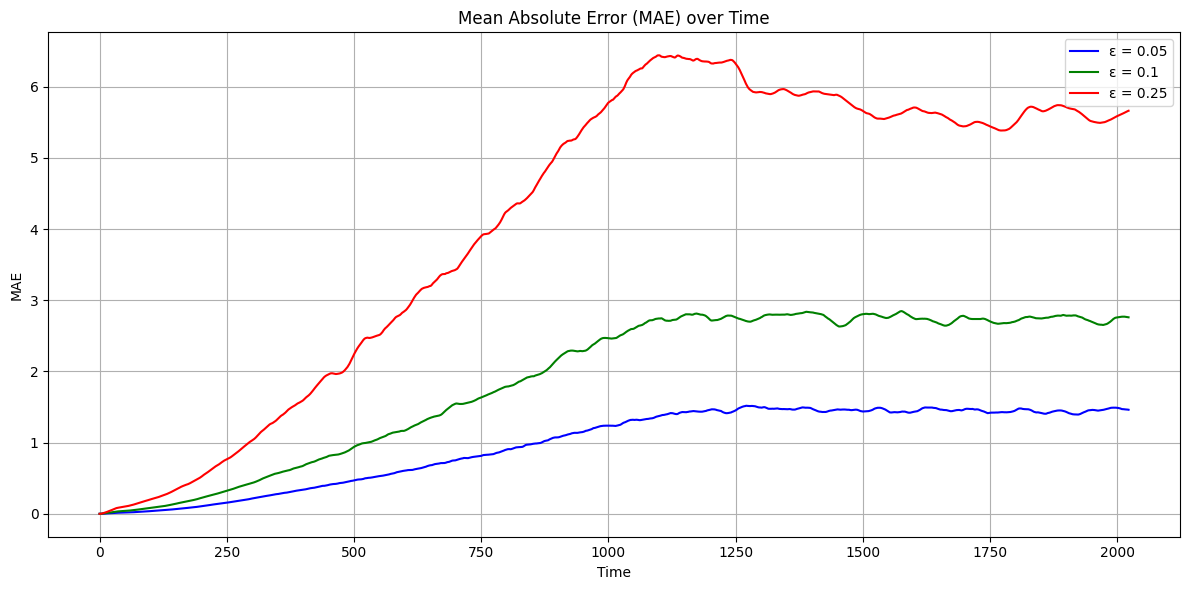

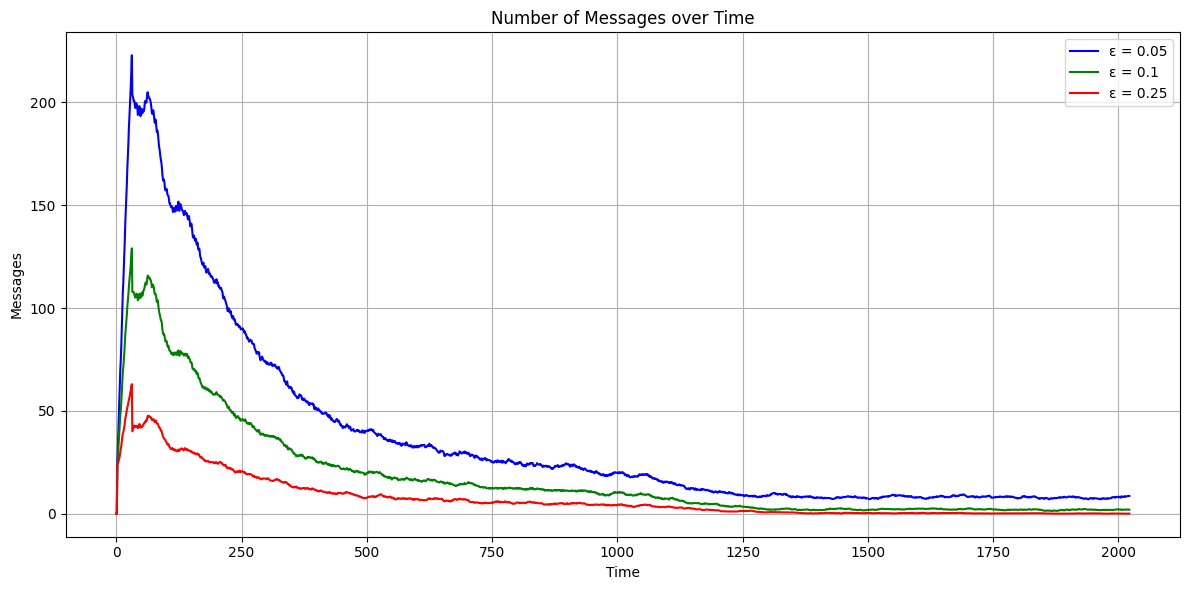

In [6]:
import matplotlib.pyplot as plt

# Re-calculate the message counts and errors using only the previous 30 data points for moving average
def calculate_messages_and_errors(epsilon, values):
    # Initialize placeholders
    last_shared_values = np.zeros_like(values)
    absolute_errors = np.zeros(values.shape[0])
    msg_counts = np.zeros(values.shape[0], dtype=int)
    last_shared_values[0, :] = values[0, :]
    
    # Track the shared values and message counts for each time point
    for i in range(1, values.shape[0]):
        relative_diff = np.abs(values[i, :] - last_shared_values[i-1, :]) / np.abs(last_shared_values[i-1, :])
        send_msg = relative_diff > epsilon
        msg_counts[i] = np.sum(send_msg)
        last_shared_values[i, send_msg] = values[i, send_msg]
        last_shared_values[i, ~send_msg] = last_shared_values[i-1, ~send_msg]
        
        # Calculate the absolute error for each time point
        absolute_errors[i] = np.mean(np.abs(values[i, :] - last_shared_values[i, :]))
    
    return msg_counts, absolute_errors

def moving_average(data, window_size=30):
    """Computes the moving average with given window size using only previous data."""
    padded_data = np.pad(data, (window_size, 0), 'edge')
    return np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')

# Different colors for each epsilon
colors = ['blue', 'green', 'red']

# Plotting the graph for MAE
plt.figure(figsize=(12, 6))

for idx, eps in enumerate(epsilons):
    _, errors = calculate_messages_and_errors(eps, cpu_values)
    ma_errors = moving_average(errors)
    
    plt.plot(ma_errors, color=colors[idx], label=f"ε = {eps}")

plt.title("Mean Absolute Error (MAE) over Time")
plt.xlabel("Time")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the graph for Message counts
plt.figure(figsize=(12, 6))

for idx, eps in enumerate(epsilons):
    msg_counts, _ = calculate_messages_and_errors(eps, cpu_values)
    ma_msg_counts = moving_average(msg_counts)
    
    plt.plot(ma_msg_counts, color=colors[idx], label=f"ε = {eps}")

plt.title("Number of Messages over Time")
plt.xlabel("Time")
plt.ylabel("Messages")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Based on the data plots,a concise analysis of the results is listed below:

1. **Mean Absolute Error (MAE)**:
   - The MAE chart reveals that as ε increases, the error also rises. Specifically, the error is relatively minimal for ε = 0.05 and peaks for ε = 0.25.
   - This is expected, as a larger ε means that nodes share their value with the coordinator only when there's a significant change in CPU usage. As a result, the coordinator is more likely to remember an outdated value, leading to a larger error.

2. **Message Counts**:
   - From the message counts plot, it's evident that the number of messages sent diminishes with an increase in ε. The highest number of messages is sent for ε = 0.05  and the least for ε = 0.25.
   - This is also anticipated. A larger ε implies that nodes share their current value only when there's a considerable change compared to the last shared value. This results in fewer messages being sent.

3. **Trade-off**:
   - A clear trade-off is visible from both charts: reducing the number of messages sent (i.e., opting for a larger ε) results in an increase in error. Conversely, to minimize error, it might need to send more messages.
   - Such trade-offs are frequently encountered in system design, especially in resource-constrained environments like wireless networks. In such settings, reducing message counts can save energy, but this might come at the cost of data quality.

4. **Conclusion**:
   - Selecting an appropriate ε is crucial as it directly affects system performance and efficacy. Depending on system requirements (e.g., the need for timely accurate data versus the need to save on communication costs), one can choose an apt ε to strike the right balance.
